In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
plt.rcParams["figure.figsize"] = (20,10)


In [ ]:
#%%
df = pd.read_csv('dataset.csv')

# remove spaces in columns name
df.columns = df.columns.str.replace(' ','_')

# splitting two WT in different dataset using location of turbine
grouped = df.groupby(df.unitlocation)
wtg40 = grouped.get_group("WTG40")

# get failure times
fault_time_wtg40 = wtg40.failure_time.unique()

# get the failure status in dataset
wtg40['total_runtime'] = [i*10 for i in range(1,len(wtg40)+1)]
wtg40['is_fault'] = wtg40['total_runtime']< fault_time_wtg40.max()

# remove some columns that are unnecessary
df = wtg40.drop(['unitlocation', 'ttimestamplocal','total_runtime', 'failure_time'], axis=1)

df['is_fault'] = df['is_fault'].astype('category')
df['is_fault'] = df['is_fault'].cat.codes
# final datasets for training
y = df['is_fault']
x= df.drop(['is_fault'],  axis=1)
x.describe()



,windspeed,power,wind_direction_Angle,rtr_rpm,pitch_Angle,generation,wheel_hub_temperature,ambient_Temperature,Tower_bottom_ambient_temperature
count,23007.000000,23007.000000,23007.000000,23007.000000,23007.000000,2.300700e+04,23007.000000,23007.000000,23007.000000
mean,5.266505,807.210862,162.210176,7.955281,7.853157,4.773937e+06,25.389703,18.954822,31.404872
std,2.907096,790.496273,58.835231,3.793158,20.690657,9.504505e+05,6.522374,7.718268,5.043819
min,0.020000,-29.840000,0.000000,0.210000,-0.580000,2.872434e+06,0.000000,-2.850000,15.570000
25%,3.080000,105.230000,174.190000,5.190000,-0.520000,3.964530e+06,20.100000,13.160000,27.600000
50%,4.960000,508.220000,179.830000,8.610000,-0.490000,4.954683e+06,27.060000,20.500000,32.390000
75%,7.100000,1471.725000,184.650000,11.660000,2.340000,5.658331e+06,30.800000,24.900000,35.040000
max,19.210000,2218.580000,352.340000,12.480000,90.470000,5.981768e+06,37.210000,36.210000,44.830000


In [ ]:
# check there is any null value present in dataset or not
print(x.isnull().values.any())
# 1 -> outlier  and 0-> normal
y

False


0        1
1        1
2        1
3        1
4        1
        ..
23002    0
23003    0
23004    0
23005    0
23006    0
Name: is_fault, Length: 23007, dtype: int8

In [ ]:
# Apply PCA to reduce dimensionality reduction
fatures_name = x.columns.tolist()
x_std = StandardScaler().fit_transform(x)
x_std = pd.DataFrame(x_std,columns= fatures_name)
x_std.head(5)


,windspeed,power,wind_direction_Angle,rtr_rpm,pitch_Angle,generation,wheel_hub_temperature,ambient_Temperature,Tower_bottom_ambient_temperature
0,-1.491729,-1.021167,-2.757084,-1.997134,2.03656,-2.000677,-2.276782,-2.095700,-2.380167
1,-1.533008,-1.021167,-2.757084,-1.999771,2.03656,-2.000677,-2.267583,-2.093109,-2.443612
2,-1.619006,-1.021167,-2.757084,-2.002407,2.03656,-2.000677,-2.218520,-2.098291,-2.392063
3,-1.653406,-1.021167,-2.757084,-2.002407,2.03656,-2.000677,-2.259917,-2.103474,-2.396028
4,-1.656846,-1.021167,-2.757084,-2.010316,2.03656,-2.000677,-2.264516,-2.090517,-2.421803


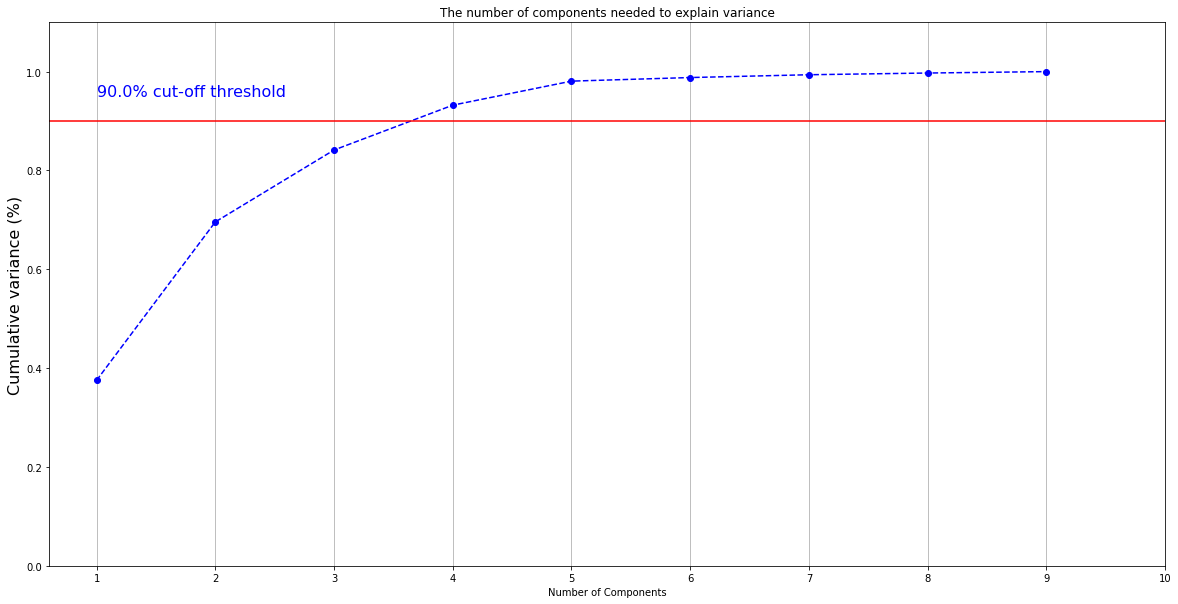

In [ ]:
pca_ = PCA().fit(x_std)
desired_variance = 0.90
fig, ax = plt.subplots()
yi = np.cumsum(pca_.explained_variance_ratio_)
xi = np.arange(1, yi.shape[0]+1, step=1)
plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, yi.shape[0]+2, step=1))
plt.ylabel('Cumulative variance (%)', fontsize=16)
plt.title('The number of components needed to explain variance')
plt.axhline(y=desired_variance, color='r', linestyle='-')
plt.text(1, desired_variance+ 0.05, str(desired_variance*100) +'% cut-off threshold', color='b', fontsize=16)
ax.grid(axis='x')
plt.show()


In [ ]:
# from above figure to acheive 0.95 explained varience we need 5 components
pca = PCA(n_components=2)
X = pca.fit_transform(x_std)
X

array([[-0.35104603,  2.97913512],
       [-0.36204073,  3.01016619],
       [-0.42436286,  2.99481883],
       ...,
       [ 4.44375194,  2.82710526],
       [ 4.4187954 ,  2.82486931],
       [ 4.39452195,  2.86047325]])

In [ ]:
# variance ratio of each components
pca.explained_variance_ratio_


array([0.37528614, 0.32053537])

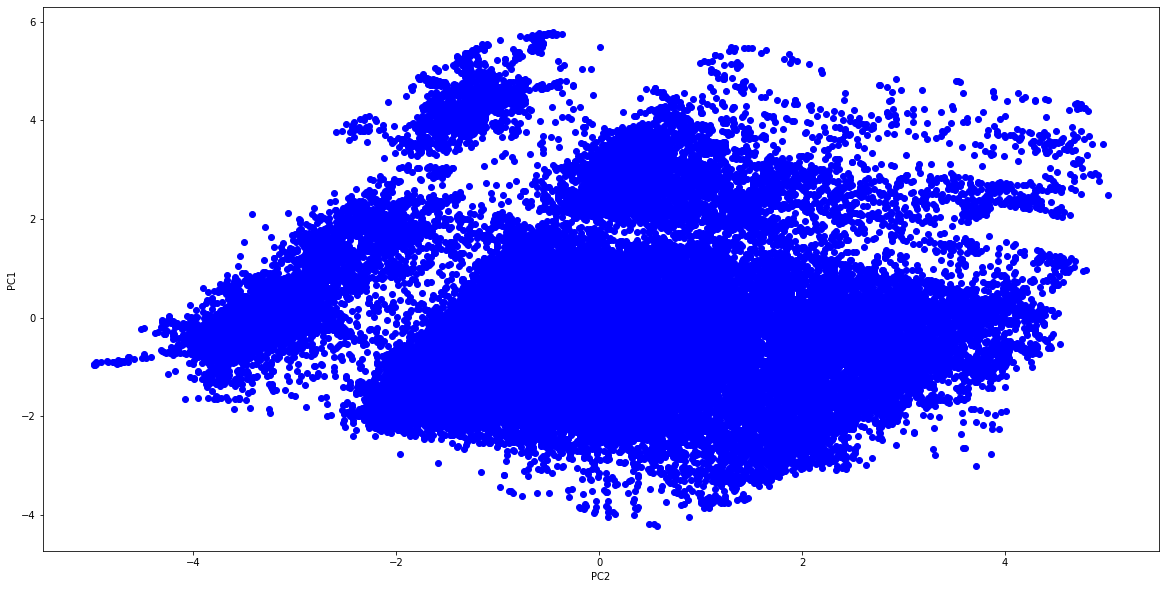

In [ ]:
plt.scatter(X[:,0], X[:,1], color='blue')
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.show()


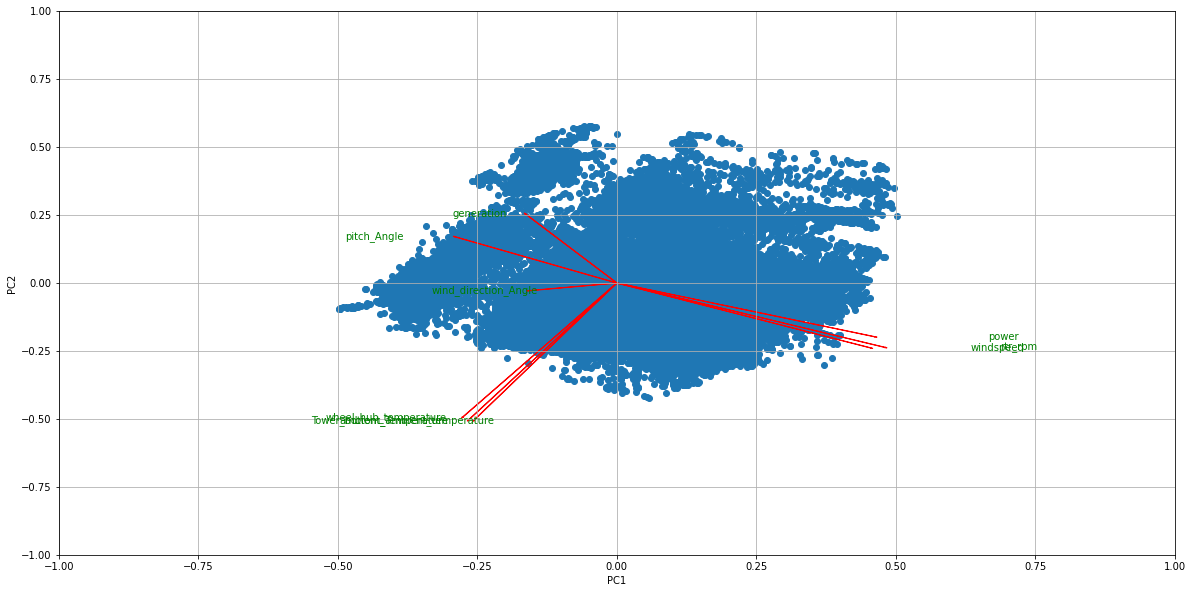

In [ ]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs*scalex, ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r')
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'r', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.5, coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
myplot(X[:,0:2],np.transpose(pca.components_[0:2, :]),fatures_name)
plt.show()


In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [fatures_name[most_important[i]] for i in range(n_pcs)]
most_important_names


['rtr_rpm', 'Tower_bottom_ambient_temperature']

In [ ]:
# splitting testing and training set
X_train =X[:35000]
X_test = X[35000:42592]
y_train = y[:35000]
y_test = y[35000:42592]


In [ ]:
# fit the model for hyper parameter tunning
clf = OneClassSVM(nu=0.25, gamma=0.35)
clf.fit(X_train)


OneClassSVM(gamma=0.35, nu=0.25)

In [ ]:
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-3, high=3, size=(10, 2))

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# error 
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size


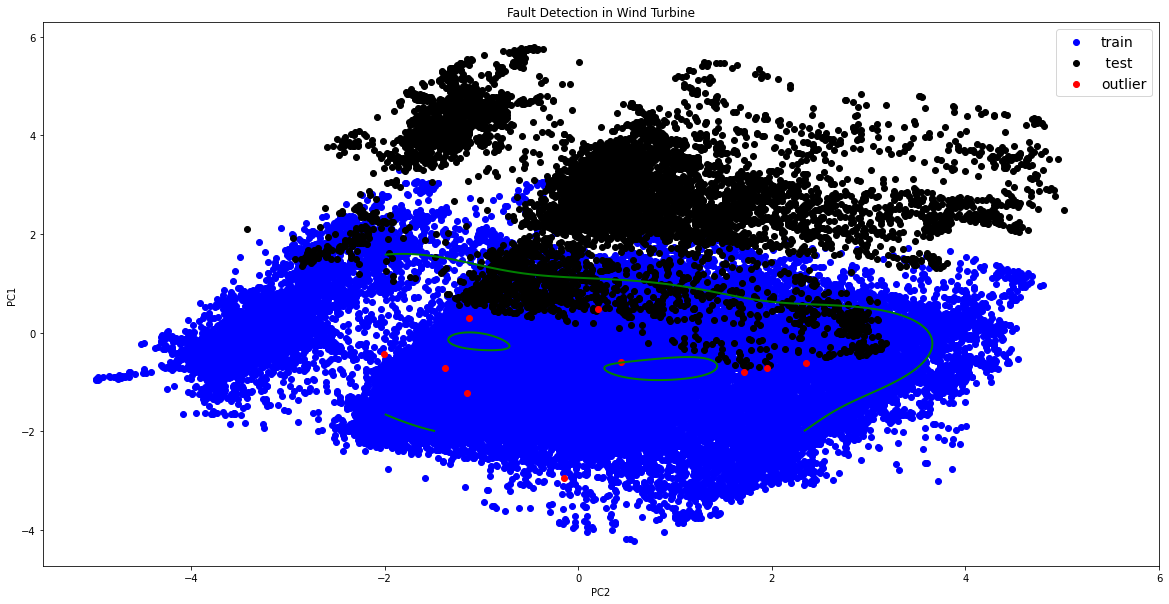

In [ ]:
# plot the result in two dimensional space
# this part of code will not work if you dont use PCA
xx, yy = np.meshgrid(np.linspace(-2, 6, 500), np.linspace(-2, 4, 500))
plt.figure(1)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend1 = {}
legend1["boundry"] = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='green')
legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())
plt.figure(1)  
plt.title("Fault Detection in Wind Turbine")
plt.scatter(X_train[:, 0], X_train[:, 1], color='blue')
plt.scatter(X_test[:, 0], X_test[:, 1], color='black')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red')
#plt.xlim((xx.min(), xx.max()))
#plt.ylim((yy.min(), yy.max()))
plt.legend([legend1_values_list[0].collections[0]],     
           labels= ["train"," test",'outlier'],
           loc="best",
           prop=matplotlib.font_manager.FontProperties(size=14))
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.show()
